## Statistical arbitrage

Statistical arbitrage using cointegration

### Import libs

In [1]:
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
n_years = 3
n_days = 365 * n_years
print(n_days)

1095


### Functions

In [3]:
def eval_division(val, m=5): 
    if val%m == 0:
        return True
    else:
        return False
    
def mask_idx(idx, m=5): 
    nulls = (
        np.array(
            [eval_division(x, m=m) for _, x in enumerate(idx)],
            dtype=bool
        )
    )
    return nulls

### Load data

In [4]:
tickers = ['MSFT', 'AAPL', '^GSPC']
assets = {}

for ticker in tickers:
    print(f'Gathering data for {ticker} for the past {n_years} years')
    data = (
        yf.download(
            tickers=ticker,
            start=dt.date.today() - dt.timedelta(n_days),
            end=dt.datetime.today()
        )
    )    
    assets[ticker] = data

Gathering data for MSFT for the past 3 years
[*********************100%***********************]  1 of 1 completed
Gathering data for AAPL for the past 3 years
[*********************100%***********************]  1 of 1 completed
Gathering data for ^GSPC for the past 3 years
[*********************100%***********************]  1 of 1 completed


#### Format columns

In [5]:
for key in assets.keys(): 
    print(f'Fixing data for {key}')
    assets[key].reset_index(inplace=True)
    assets[key]['Date'] = (
        assets[key]['Date']
        .apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
    )

Fixing data for MSFT
Fixing data for AAPL
Fixing data for ^GSPC


#### S&P500

/Users/tiagodosreis/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/tiagodosreis/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Date')

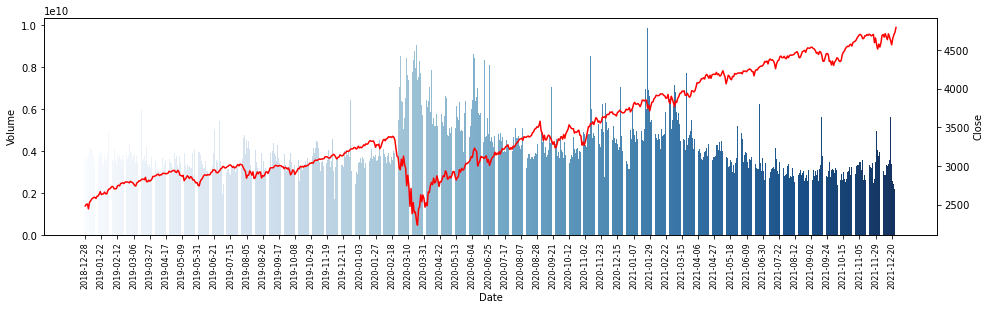

In [8]:
fig, ax_ = plt.subplots(1,1,figsize=(16,4))

ax = ax_.twinx()

nulls = mask_idx(assets['^GSPC'].index, m=15)
sns.barplot(assets['^GSPC'].index, assets['^GSPC']['Volume'], ax=ax_, palette='Blues')
sns.lineplot(assets['^GSPC'].index, assets['^GSPC']['Close'], ax=ax, color='Red')
ax_.set_xticks(assets['^GSPC'].index[nulls])
ax_.set_xticklabels(assets['^GSPC']['Date'][nulls], rotation=90, fontsize=8)
ax_.set_xlabel('Date')

#### AAPL & MSFT

/Users/tiagodosreis/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/tiagodosreis/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/tiagodosreis/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

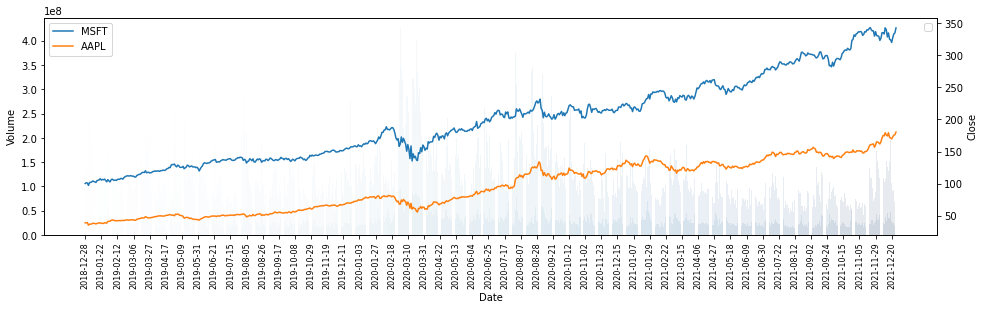

In [15]:
fig, ax_ = plt.subplots(1,1,figsize=(16,4))

ax = ax_.twinx()

for key in list(assets.keys())[:-1]:

    nulls = mask_idx(assets[key].index, m=15)
    sns.barplot(assets[key].index, assets[key]['Volume'], ax=ax_, palette='Blues', alpha=0.1)
    sns.lineplot(assets[key].index, assets[key]['Close'], ax=ax, label=f'{key}')
    
ax_.set_xticks(assets[key].index[nulls])
ax_.set_xticklabels(assets[key]['Date'][nulls], rotation=90, fontsize=8)
ax_.set_xlabel('Date')
ax_.legend()